In [46]:
import os, time, copy, math
from pathlib import Path
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import models, datasets
import torch.nn.functional as F

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, 
    confusion_matrix, classification_report, f1_score
)
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
torch.backends.cudnn.benchmark = True

Device: cuda


In [48]:
work_dir = os.path.abspath("..")  

# 新的数据目录结构：train 和 test 分开
train_data_dir = os.path.join(work_dir, "dataprocess", "augmented", "train")  # 训练数据 (来自 original)
test_data_dir = os.path.join(work_dir, "dataprocess", "augmented", "test")    # 测试数据 (来自 bad_samples)

save_dir = os.path.join(work_dir, "Mobilenetv3-Large", "checkpoints")  # 模型保存路径
result_dir = os.path.join(work_dir, "Mobilenetv3-Large", "results")    # 结果保存路径
os.makedirs(save_dir, exist_ok=True)

print("当前工作目录:", work_dir)
print("训练数据目录:", train_data_dir)
print("测试数据目录:", test_data_dir)
print("模型保存目录:", save_dir)
print("模型结果目录:", result_dir)

# 从训练目录获取类别数
num_classes = len([d for d in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir, d))])
print("类别数:", num_classes)

当前工作目录: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork
训练数据目录: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork\dataprocess\augmented\train
测试数据目录: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork\dataprocess\augmented\test
模型保存目录: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork\Mobilenetv3-Large\checkpoints
模型结果目录: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork\Mobilenetv3-Large\results
类别数: 8


In [49]:
CFG = {
    "model_name": "mobilenet_v3_large",   
    "img_size": 224,
    "batch_size": 32,     # 32,16
    "stage1_epochs": 10,      # 阶段1：只训练分类头
    "stage2_epochs": 5,      # 阶段2：微调所有层
    "lr_stage1": 1e-3,        # 阶段1学习率
    "lr_stage2": 1e-5,        # 阶段2学习率（降低10倍）
    "weight_decay": 2e-4,
    "num_workers": 4,
    "save_path": save_dir, #模型结果
    "result_path": result_dir, #模型训练结果
    "accumulation_steps": 1,  # 如果显存小可 >1 做梯度累积
    "early_stopping_patience":8,  # 提前停止的耐心值
    "use_mixup": True,       # 训练时可选择开启 Mixup
    "mixup_alpha": 0.4,
}

In [50]:
# data trasnsforms
from torchvision import datasets, transforms
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(p=0.5),#水平翻转
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),#增强颜色变化
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),# 平移
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0),#随机遮挡图片区域，必须在ToTensor之后
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}



In [51]:
# mixup 增强
def mixup_data(x, y, alpha=0.2, device='cuda'):
    """
    Mixup数据增强
    关键：混合不同类别的样本，创建软标签
    """
    if alpha <= 0:
        return x, y, None, 1.0
    
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    Mixup损失函数
    混合两个标签的损失：L = λ*L(pred, y_a) + (1-λ)*L(pred, y_b)
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## Mixup 数据增强原理解释

### `mixup_data` 函数



In [ ]:
# def mixup_data(x, y, alpha=0.2, device='cuda'):
#     lam = np.random.beta(alpha, alpha)  # 从Beta分布采样混合比例
#     index = torch.randperm(batch_size).to(device)  # 随机打乱索引
    
#     mixed_x = lam * x + (1 - lam) * x[index, :]  # 混合两张图片
#     y_a, y_b = y, y[index]  # 保留两个标签
    
#     return mixed_x, y_a, y_b, lam



**核心思想**：将两张不同的图片按比例混合，创建"软标签"

**传统训练的问题**：

模型只学习"硬标签"：一张图要么是香蕉(100%)，要么是樱桃(100%)
这导致模型过于自信，决策边界过于"尖锐"
容易过拟合，对噪声敏感

**举例说明**：
- 假设有一张🍌香蕉图片 (标签=0) 和一张🍒樱桃图片 (标签=1)
- 采样得到 $\lambda = 0.7$
- 混合后的图片 = $0.7 \times 🍌 + 0.3 \times 🍒$
- 这张新图片同时具有两个标签：70%是香蕉，30%是樱桃



传统：图片A → 标签[1, 0, 0, 0, 0, 0, 0, 0]  (100%香蕉)

Mixup：图片A×0.7 + 图片B×0.3 → 标签[0.7, 0.3, 0, 0, 0, 0, 0, 0]  (70%香蕉 + 30%樱桃)

原图A (香蕉)     原图B (樱桃)      混合结果
   🍌      +        🍒       =    🍌🍒混合图
  λ=0.7          1-λ=0.3



---

### `mixup_criterion` 函数



In [ ]:
# def mixup_criterion(criterion, pred, y_a, y_b, lam):
#     return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)



**对应的损失函数**：按同样的比例混合两个标签的损失

$$L_{mixup} = \lambda \cdot L(pred, y_a) + (1-\lambda) \cdot L(pred, y_b)$$

继续上面的例子：
- 模型预测这张混合图片
- 损失 = $0.7 \times Loss(预测, 香蕉) + 0.3 \times Loss(预测, 樱桃)$

---

### 为什么有效？

| 优点 | 说明 |
|------|------|
| **正则化** | 强迫模型学习更平滑的决策边界 |
| **减少过拟合** | 相当于无限扩充训练数据 |
| **提高鲁棒性** | 模型不会对单一特征过度自信 |
| **校准置信度** | 输出概率更可靠 |

### Alpha参数的影响

- $\alpha$ 控制 Beta 分布的形状
- $\alpha = 0.2$（你的设置）：$\lambda$ 倾向于接近 0 或 1（轻度混合）
- $\alpha = 1.0$：$\lambda$ 均匀分布（强力混合）
- $\alpha$ 越大，混合越激进

In [52]:
# ========== 数据加载 ==========
# aug_train_dir：用于划分训练集和验证集 (7:3)
# aug_test_dir：直接作为测试集
# 训练/验证集与测试集来自不同的原始图片，无数据泄露！

import random
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== 加载训练/验证数据 ==========
# 训练集使用训练增强，验证集使用无增强（两个独立的 ImageFolder 实例）
train_full_dataset = datasets.ImageFolder(
    root=train_data_dir,
    transform=data_transforms["train"]
)

val_full_dataset = datasets.ImageFolder(
    root=train_data_dir,
    transform=data_transforms["val"]
)

# 划分训练集和验证集 (70% 训练, 30% 验证)
total_train_size = len(train_full_dataset)
all_indices = list(range(total_train_size))
random.shuffle(all_indices)

train_split = int(0.70 * total_train_size)  # 70% 用于训练
train_indices = all_indices[:train_split]
val_indices = all_indices[train_split:]

train_dataset = Subset(train_full_dataset, train_indices)
val_dataset = Subset(val_full_dataset, val_indices)

print(f"aug_train_dir 总样本数: {total_train_size}")
print(f"训练集大小 (70%): {len(train_indices)}")
print(f"验证集大小 (30%): {len(val_indices)}")

# ========== 加载测试数据 ==========
test_dataset = datasets.ImageFolder(
    root=test_data_dir,
    transform=data_transforms["val"]  # 测试集不使用数据增强
)

print(f"测试集大小 (100%): {len(test_dataset)}")

# ========== 创建 DataLoader ==========
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG["batch_size"],
    shuffle=True,
    num_workers=CFG["num_workers"],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CFG["batch_size"],
    shuffle=False,
    num_workers=CFG["num_workers"],
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CFG["batch_size"],
    shuffle=False,
    num_workers=CFG["num_workers"],
    pin_memory=True
)

# 保存 full_dataset 引用供后续使用
full_dataset = train_full_dataset

print(f"\nClasses: {full_dataset.classes}")
print(f"Train Batches: {len(train_loader)}")
print(f"Val Batches:   {len(val_loader)}")
print(f"Test Batches:  {len(test_loader)}")

print("\n" + "=" * 50)
print("数据划分说明：")
print("=" * 50)
print("训练集：来自 aug_train_dir (70%)")
print("验证集：来自 aug_train_dir (30%)")
print("测试集：来自 aug_test_dir (100%)")

aug_train_dir 总样本数: 5295
训练集大小 (70%): 3706
验证集大小 (30%): 1589
测试集大小 (100%): 2120

Classes: ['Cherry', 'Cucumber', 'Pearl_millet(bajra)', 'Tobacco-plant', 'banana', 'cotton', 'maize', 'wheat']
Train Batches: 116
Val Batches:   50
Test Batches:  67

数据划分说明：
训练集：来自 aug_train_dir (70%)
验证集：来自 aug_train_dir (30%)
测试集：来自 aug_test_dir (100%)


In [53]:
def train_epoch(model, train_loader, criterion, optimizer, device, 
                use_mixup=True, mixup_alpha=0.2):
    """训练一个epoch"""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        if use_mixup:
            images, labels_a, labels_b, lam = mixup_data(
                images, labels, alpha=mixup_alpha
            )
        
        outputs = model(images)
        
        if use_mixup:
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            _, preds = torch.max(outputs, 1)
            if lam >= 0.5:
                running_corrects += torch.sum(preds == labels_a.data)
            else:
                running_corrects += torch.sum(preds == labels_b.data)
        else:
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        total_samples += labels.size(0)
        
        pbar.set_postfix({'loss': running_loss / total_samples})
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    
    return epoch_loss, epoch_acc.item()

In [54]:
def validate_epoch(model, val_loader, criterion, device):
    """验证一个epoch"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating", leave=False)
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
            
            pbar.set_postfix({'loss': running_loss / total_samples})
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    
    return epoch_loss, epoch_acc.item()

In [55]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0005, save_path="best_model.pth", best_model_path=None):
        """
        patience：多少 epoch 内没有提升就停止
        delta：最小提升幅度
        save_path：最优模型保存路径
        best_model_path：最优模型保存路径（兼容参数）
        """
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.delta = delta
        self.save_path = best_model_path if best_model_path else save_path
        self.best_model_path = self.save_path
        self.early_stop = False
        self.best_epoch=0

    def __call__(self, val_loss, model,epoch):
        # 第一次直接保存
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model, epoch)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
        else:
            self.best_loss = val_loss
            self.counter =0
            self.save_checkpoint(model, epoch)

        return self.counter >= self.patience
    
    def save_checkpoint(self, model, epoch):
        torch.save(model.state_dict(), self.best_model_path)
        self.best_epoch = epoch

In [56]:
def create_model(num_classes,device):
    from torchvision.models import mobilenet_v3_large
    from torchvision.models import MobileNet_V3_Large_Weights

    # 加载预训练模型
    weight = MobileNet_V3_Large_Weights.DEFAULT
    model = mobilenet_v3_large(weights=weight)

    # 冻结backbone权重
    for param in model.features.parameters():
        param.requires_grad = False #冻结梯度 

    # 修改分类头 别的不做修改
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, num_classes)
    print(model)

    in_features = model.classifier[0].in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_features, 512),  #out_features1280 -> 512
    nn.BatchNorm1d(512),  #批标准化
    nn.ReLU(inplace=True), #ReLU激活
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),  #out_features 512 -> 256
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    
    nn.Linear(256, num_classes) #最终分类层 out_features 512 -> 256
    )
    
    return model.to(device)

In [57]:
def train_two_stage_no_fold(model, train_loader, val_loader, device, CFG):
    """
    两步走训练策略 - 无交叉验证版本（快速训练）
    Stage 1: 冻结backbone，只训练分类头 (学习率大)
    Stage 2: 解冻所有层，微调整个模型 (学习率小)
    """
    
    criterion = nn.CrossEntropyLoss()
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    total_epochs = CFG["stage1_epochs"] + CFG["stage2_epochs"]
    
    # ========== 阶段1: 只训练分类头 ==========
    print(f"\n{'='*60}")
    print(f"阶段1: 训练分类头 (Backbone冻结)")
    print(f"学习率: {CFG['lr_stage1']}, Epochs: {CFG['stage1_epochs']}")
    print(f"{'='*60}")
    
    optimizer1 = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=CFG["lr_stage1"],
        weight_decay=CFG["weight_decay"]
    )
    
    scheduler1 = optim.lr_scheduler.CosineAnnealingLR(
        optimizer1, T_max=CFG["stage1_epochs"]
    )
    
    early_stopping1 = EarlyStopping(
        patience=CFG["early_stopping_patience"],
        best_model_path=os.path.join(CFG["save_path"], "best_model_stage1.pth")
    )
    
    for epoch in range(CFG["stage1_epochs"]):
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer1, device,
            use_mixup=CFG["use_mixup"], mixup_alpha=CFG["mixup_alpha"]
        )
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler1.step()
        current_lr = optimizer1.param_groups[0]['lr']
        
        print(f"Epoch [{epoch+1}/{CFG['stage1_epochs']}] "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
              f"LR: {current_lr:.6f}")
        
        if early_stopping1(val_loss, model, epoch):
            print(f"⚡ 阶段1早停 (epoch {epoch+1}，最优epoch: {early_stopping1.best_epoch+1})")
            break
    
    # ========== 阶段2: 微调所有层 ==========
    print(f"\n{'='*60}")
    print(f"阶段2: 微调所有层 (解冻Backbone)")
    print(f"学习率: {CFG['lr_stage2']}, Epochs: {CFG['stage2_epochs']}")
    print(f"{'='*60}")
    
    # 解冻所有参数
    for param in model.parameters():
        param.requires_grad = True
    
    optimizer2 = optim.AdamW(
        model.parameters(),
        lr=CFG["lr_stage2"],
        weight_decay=CFG["weight_decay"]
    )
    
    scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer2, mode='min', factor=0.5, patience=3, verbose=False, min_lr=1e-6
    )
    
    early_stopping2 = EarlyStopping(
        patience=CFG["early_stopping_patience"],
        best_model_path=os.path.join(CFG["save_path"], "best_model.pth")
    )
    
    for epoch in range(CFG["stage2_epochs"]):
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer2, device,
            use_mixup=CFG["use_mixup"], mixup_alpha=CFG["mixup_alpha"]
        )
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler2.step(val_loss)
        current_lr = optimizer2.param_groups[0]['lr']
        
        print(f"Epoch [{CFG['stage1_epochs']+epoch+1}/{total_epochs}] "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
              f"LR: {current_lr:.6f}")
        
        if early_stopping2(val_loss, model, epoch):
            print(f"⚡ 阶段2早停 (epoch {CFG['stage1_epochs']+epoch+1}，最优epoch: {CFG['stage1_epochs']+early_stopping2.best_epoch+1})")
            break
    
    # 训练完成总结
    print(f"\n{'='*60}")
    print(f"最优模型已保存: {os.path.join(CFG['save_path'], 'best_model.pth')}")
    print(f"最终 Train Acc: {history['train_acc'][-1]:.4f}")
    print(f"最终 Val Acc: {history['val_acc'][-1]:.4f}")
    print(f"{'='*60}")
    
    return history

In [58]:
def test_model(model, test_loader, device):
    """测试模型性能"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Testing", leave=False)
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

In [59]:
# 快速训练模型（不做交叉验证）
model = create_model(num_classes, device)
history = train_two_stage_no_fold(model, train_loader, val_loader, device, CFG)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

Epoch [1/10] Train Loss: 0.9490 Acc: 0.8014 | Val Loss: 0.1691 Acc: 0.9704 | LR: 0.000976


Epoch [2/10] Train Loss: 0.7105 Acc: 0.9061 | Val Loss: 0.1225 Acc: 0.9912 | LR: 0.000905


Epoch [3/10] Train Loss: 0.7727 Acc: 0.9029 | Val Loss: 0.0968 Acc: 0.9943 | LR: 0.000794


Epoch [4/10] Train Loss: 0.6829 Acc: 0.9244 | Val Loss: 0.0882 Acc: 0.9975 | LR: 0.000655


Epoch [5/10] Train Loss: 0.7105 Acc: 0.9155 | Val Loss: 0.0973 Acc: 0.9975 | LR: 0.000500


Epoch [6/10] Train Loss: 0.7024 Acc: 0.9107 | Val Loss: 0.0777 Acc: 0.9987 | LR: 0.000345


Epoch [7/10] Train Loss: 0.6755 Acc: 0.9199 | Val Loss: 0.0741 Acc: 0.9987 | LR: 0.000206


Epoch [8/10] Train Loss: 0.7075 Acc: 0.9166 | Val Loss: 0.0806 Acc: 0.9987 | LR: 0.000095


Epoch [9/10] Train Loss: 0.6552 Acc: 0.9261 | Val Loss: 0.0777 Acc: 0.9987 | LR: 0.000024


Epoch [10/10] Train Loss: 0.6391 Acc: 0.9296 | Val Loss: 0.0785 Acc: 0.9981 | LR: 0.000000

阶段2: 微调所有层 (解冻Backbone)
学习率: 1e-05, Epochs: 5


Epoch [11/15] Train Loss: 0.5782 Acc: 0.9471 | Val Loss: 0.0691 Acc: 0.9987 | LR: 0.000010


Epoch [12/15] Train Loss: 0.6581 Acc: 0.9077 | Val Loss: 0.0678 Acc: 0.9987 | LR: 0.000010


Epoch [13/15] Train Loss: 0.6668 Acc: 0.9293 | Val Loss: 0.0608 Acc: 0.9994 | LR: 0.000010


Epoch [14/15] Train Loss: 0.6264 Acc: 0.9334 | Val Loss: 0.0641 Acc: 0.9994 | LR: 0.000010


Epoch [15/15] Train Loss: 0.6350 Acc: 0.9350 | Val Loss: 0.0587 Acc: 0.9994 | LR: 0.000010

最优模型已保存: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork\Mobilenetv3-Large\checkpoints\best_model.pth
最终 Train Acc: 0.9350
最终 Val Acc: 0.9994


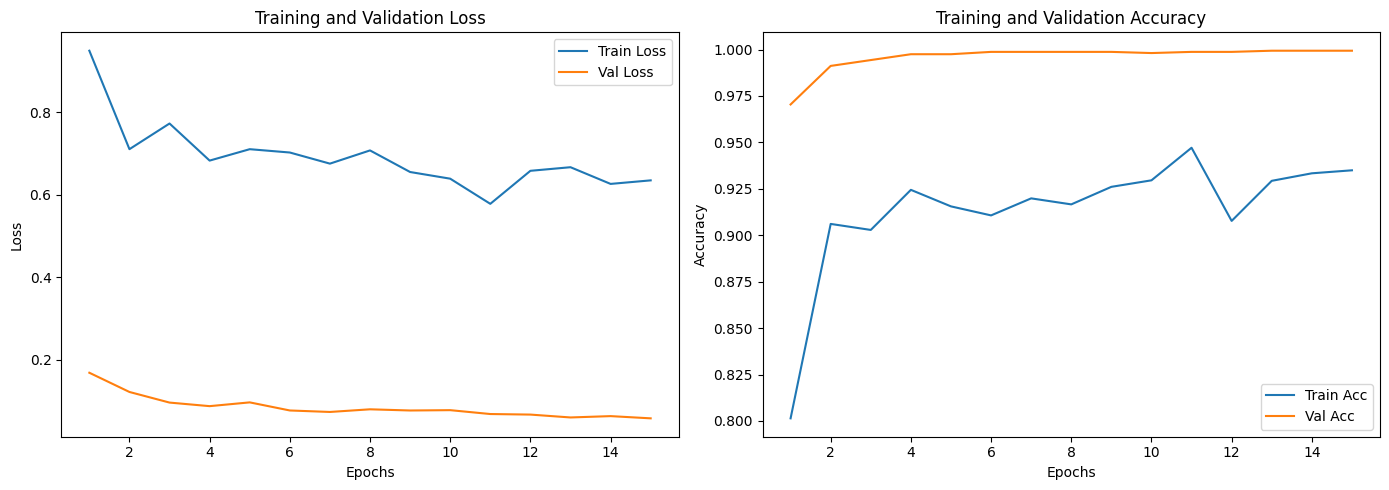

In [76]:
# 绘制训练过程的损失和准确率曲线
def plot_training_history(history, CFG):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # 损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # 准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(CFG["result_path"], 'training_history.png'), dpi=300)
    plt.show()

plot_training_history(history, CFG)

 已加载最优模型: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork\Mobilenetv3-Large\checkpoints\best_model.pth



 测试集评估结果
Test Accuracy: 93.44%
Test F1-Score (weighted): 0.9343

 分类报告:
                     precision    recall  f1-score   support

             Cherry       1.00      1.00      1.00       279
           Cucumber       0.92      0.87      0.89       279
Pearl_millet(bajra)       1.00      0.94      0.97       260
      Tobacco-plant       0.91      0.86      0.88       279
             banana       0.85      0.97      0.90       279
             cotton       0.93      0.85      0.89       248
              maize       0.88      0.99      0.93       217
              wheat       1.00      1.00      1.00       279

           accuracy                           0.93      2120
          macro avg       0.94      0.93      0.93      2120
       weighted avg       0.94      0.93      0.93      2120



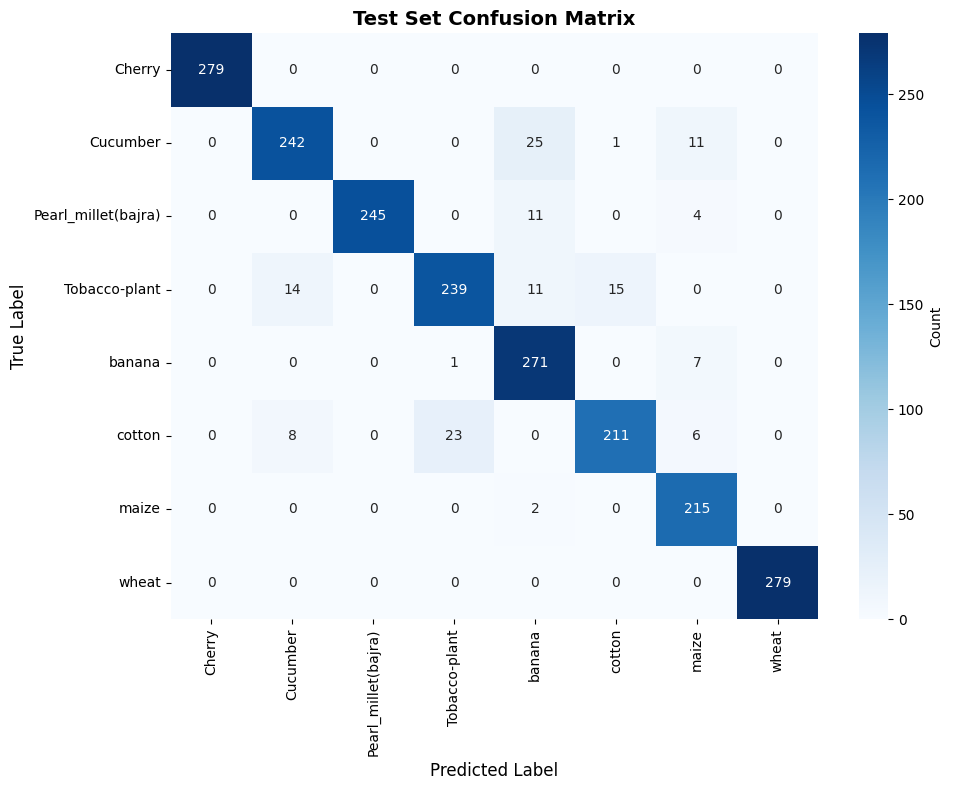

In [60]:
# 加载训练后的最优模型
best_model_path = os.path.join(CFG["save_path"], "best_model.pth")
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
print(f" 已加载最优模型: {best_model_path}")

# 在测试集上进行评估
test_labels, test_preds = test_model(model, test_loader, device)

# 计算测试集指标
test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"\n{'='*60}")
print(f" 测试集评估结果")
print(f"{'='*60}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test F1-Score (weighted): {test_f1:.4f}")
print(f"{'='*60}")

# 详细分类报告
print("\n 分类报告:")
print(classification_report(test_labels, test_preds, target_names=full_dataset.classes))

# 混淆矩阵可视化
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes,
            cbar_kws={'label': 'Count'})
plt.title('Test Set Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(CFG["result_path"], 'test_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

✅ 已加载最优模型: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork\Mobilenetv3-Large\checkpoints\best_model.pth


获取预测概率: 100%|██████████| 67/67 [00:13<00:00,  4.92it/s]



测试集样本数: 2120
类别数: 8


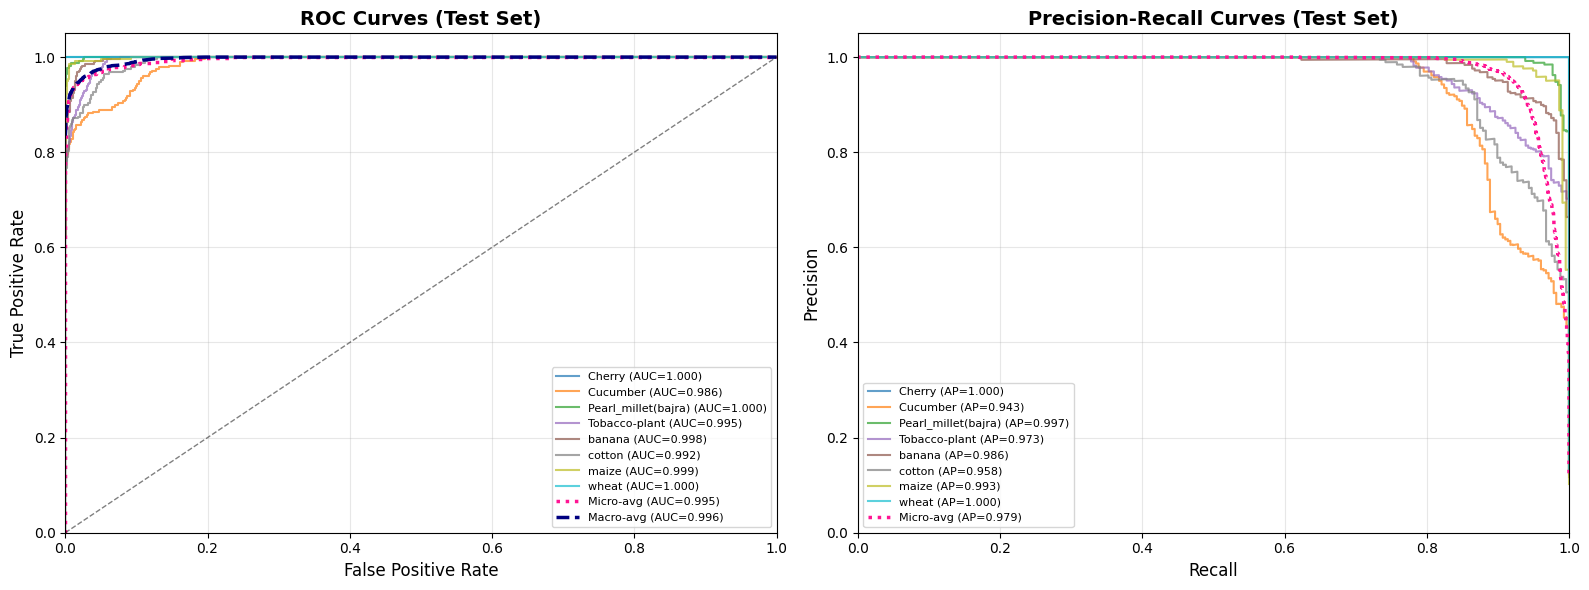


📊 ROC-AUC 和 Average Precision 汇总
类别                   |   ROC-AUC    | Avg Precision
--------------------------------------------------
Cherry               |    1.0000    |    1.0000   
Cucumber             |    0.9861    |    0.9425   
Pearl_millet(bajra)  |    0.9996    |    0.9973   
Tobacco-plant        |    0.9953    |    0.9727   
banana               |    0.9977    |    0.9859   
cotton               |    0.9925    |    0.9585   
maize                |    0.9990    |    0.9933   
wheat                |    1.0000    |    1.0000   
--------------------------------------------------
Macro Average        |    0.9963    |    0.9813   
Micro Average        |    0.9953    |    0.9788   

 ROC/PR 曲线已保存至: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork\Mobilenetv3-Large\results\roc_pr_curves.png


In [66]:
# ========== 绘制 ROC 曲线和 PR 曲线 ==========
# 注意：ROC/PR 曲线需要使用【测试集】的概率输出
# 这是评估模型最终性能的标准做法

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# 1. 加载最优模型
best_model_path = os.path.join(CFG["save_path"], "best_model.pth")
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
print(f"✅ 已加载最优模型: {best_model_path}")

# 2. 获取测试集的概率输出
def get_predictions_with_probs(model, data_loader, device):
    """获取模型预测的概率和真实标签"""
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="获取预测概率"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            
            all_probs.append(probs.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.vstack(all_probs), np.array(all_labels)

# 获取测试集预测概率
test_probs, test_labels_arr = get_predictions_with_probs(model, test_loader, device)
class_names = full_dataset.classes
n_classes = len(class_names)

print(f"测试集样本数: {len(test_labels_arr)}")
print(f"类别数: {n_classes}")

# 3. 将标签二值化（用于多分类 ROC/PR）
test_labels_bin = label_binarize(test_labels_arr, classes=range(n_classes))

# ========== 绘制 ROC 曲线 ==========
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 计算每个类别的 ROC 曲线和 AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算 micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_bin.ravel(), test_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 计算 macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 绘制 ROC 曲线
ax1 = axes[0]
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

# 绘制每个类别的 ROC
for i, color in zip(range(n_classes), colors):
    ax1.plot(fpr[i], tpr[i], color=color, lw=1.5, alpha=0.7,
             label=f'{class_names[i]} (AUC={roc_auc[i]:.3f})')

# 绘制 micro/macro 平均
ax1.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', lw=2.5,
         label=f'Micro-avg (AUC={roc_auc["micro"]:.3f})')
ax1.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', lw=2.5,
         label=f'Macro-avg (AUC={roc_auc["macro"]:.3f})')

# 绘制对角线
ax1.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curves (Test Set)', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=8)
ax1.grid(True, alpha=0.3)

# ========== 绘制 PR 曲线 ==========
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_labels_bin[:, i], test_probs[:, i])
    avg_precision[i] = average_precision_score(test_labels_bin[:, i], test_probs[:, i])

# 计算 micro-average PR
precision["micro"], recall["micro"], _ = precision_recall_curve(
    test_labels_bin.ravel(), test_probs.ravel())
avg_precision["micro"] = average_precision_score(test_labels_bin, test_probs, average="micro")

# 绘制 PR 曲线
ax2 = axes[1]

# 绘制每个类别的 PR 曲线
for i, color in zip(range(n_classes), colors):
    ax2.plot(recall[i], precision[i], color=color, lw=1.5, alpha=0.7,
             label=f'{class_names[i]} (AP={avg_precision[i]:.3f})')

# 绘制 micro-average
ax2.plot(recall["micro"], precision["micro"], color='deeppink', linestyle=':', lw=2.5,
         label=f'Micro-avg (AP={avg_precision["micro"]:.3f})')

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curves (Test Set)', fontsize=14, fontweight='bold')
ax2.legend(loc='lower left', fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CFG["result_path"], 'roc_pr_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

# ========== 打印 AUC 和 AP 汇总 ==========
print(f"\n{'='*60}")
print(f"📊 ROC-AUC 和 Average Precision 汇总")
print(f"{'='*60}")
print(f"{'类别':<20} | {'ROC-AUC':^12} | {'Avg Precision':^12}")
print("-" * 50)
for i in range(n_classes):
    print(f"{class_names[i]:<20} | {roc_auc[i]:^12.4f} | {avg_precision[i]:^12.4f}")
print("-" * 50)
print(f"{'Macro Average':<20} | {roc_auc['macro']:^12.4f} | {np.mean([avg_precision[i] for i in range(n_classes)]):^12.4f}")
print(f"{'Micro Average':<20} | {roc_auc['micro']:^12.4f} | {avg_precision['micro']:^12.4f}")
print(f"{'='*60}")

print(f"\n ROC/PR 曲线已保存至: {os.path.join(CFG['result_path'], 'roc_pr_curves.png')}")

✅ 已加载最优模型: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork\Mobilenetv3-Large\checkpoints\best_model.pth
 共选取 12 张图片进行预测展示
 共选取 12 张图片进行预测展示


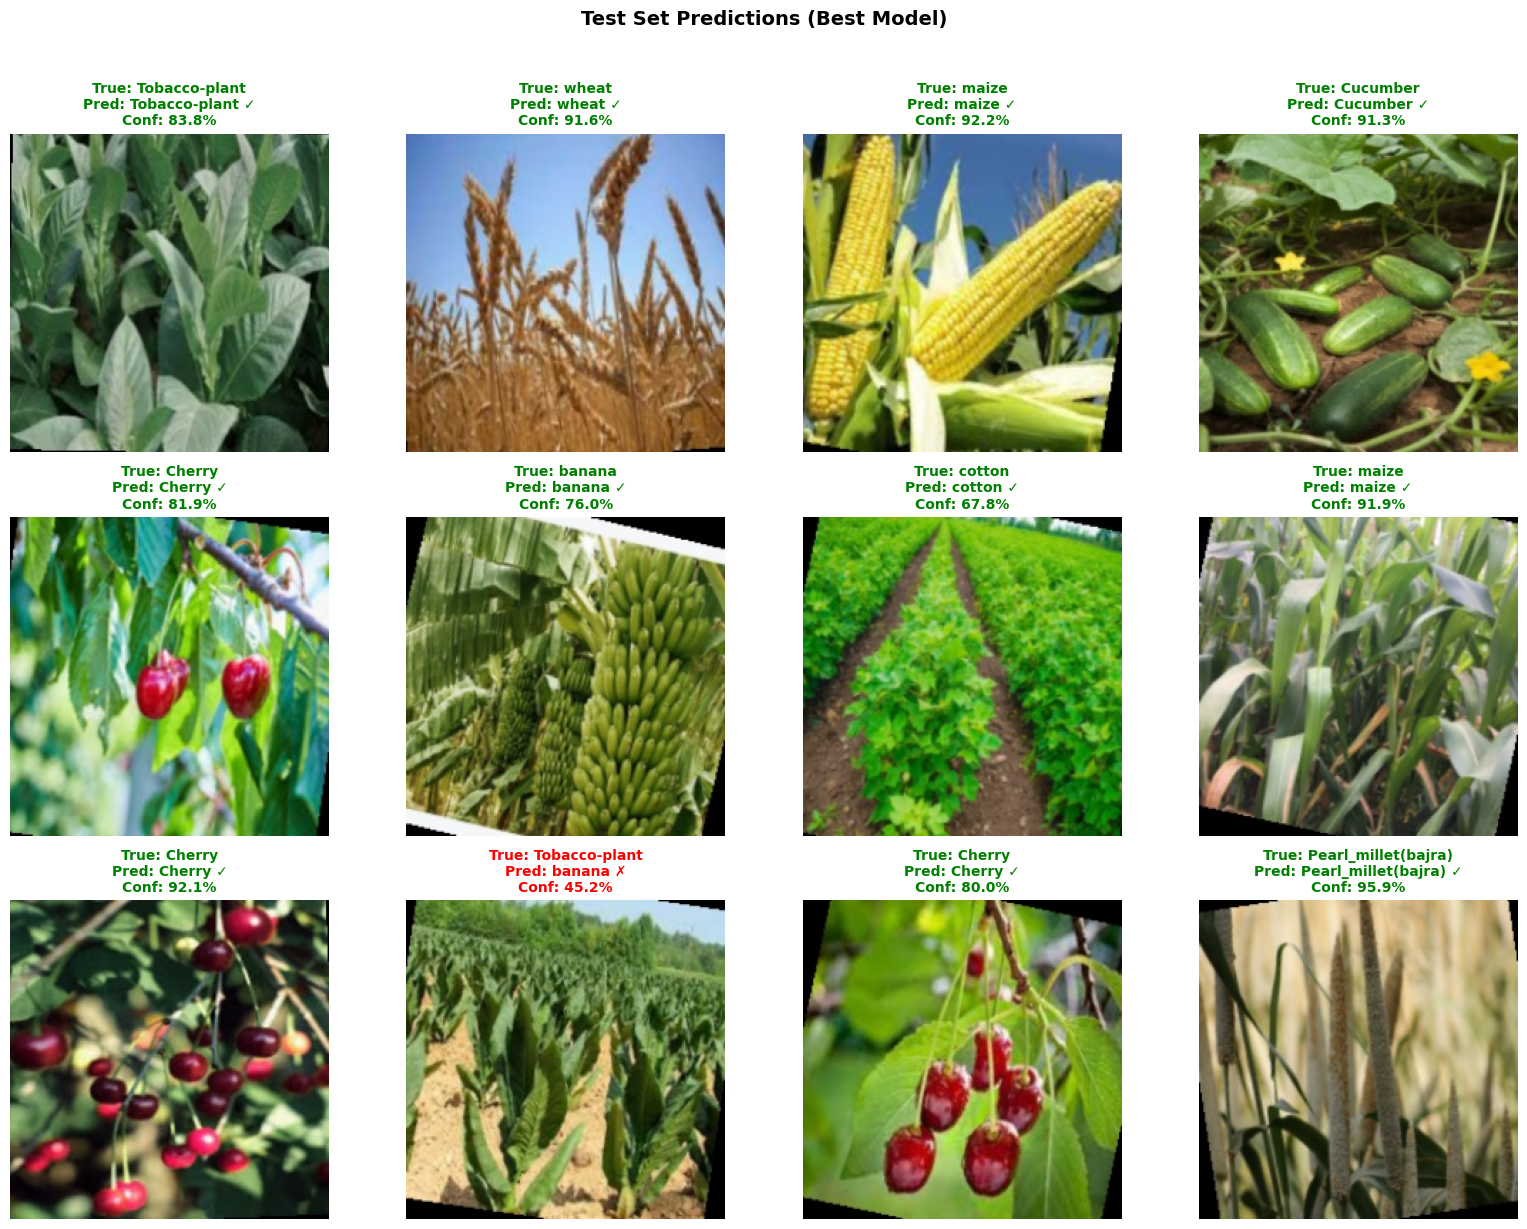


 展示样本预测统计:
   正确预测: 11/12 (91.7%)


In [72]:
# ========== 加载最优模型并对测试集进行预测展示 ==========
# 确保每个类别都有样本展示

# 1. 加载最优模型
best_model_path = os.path.join(CFG["save_path"], "best_model.pth")
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
print(f"✅ 已加载最优模型: {best_model_path}")

# 2. 从测试集中按类别采样，确保每个类别都有样本
def sample_from_each_class(test_dataset, class_names, samples_per_class=2):
    """从每个类别中随机采样指定数量的样本"""
    from collections import defaultdict
    
    # 按类别分组索引
    class_indices = defaultdict(list)
    for idx in range(len(test_dataset)):
        _, label = test_dataset[idx]
        class_indices[label].append(idx)
    
    # 从每个类别采样
    selected_indices = []
    for class_idx in range(len(class_names)):
        indices = class_indices[class_idx]
        if len(indices) > 0:
            # 随机采样（最多samples_per_class个）
            n_samples = min(samples_per_class, len(indices))
            sampled = random.sample(indices, n_samples)
            selected_indices.extend(sampled)
    
    return selected_indices

# 获取类别名称
class_names = full_dataset.classes
num_classes = len(class_names)

# 每个类别采样的数量（确保总数约为12张）
samples_per_class = max(1, 12 // num_classes)
selected_indices = sample_from_each_class(test_dataset, class_names, samples_per_class)

# 如果不足12张，随机补充
if len(selected_indices) < 12:
    remaining = list(set(range(len(test_dataset))) - set(selected_indices))
    extra = random.sample(remaining, min(12 - len(selected_indices), len(remaining)))
    selected_indices.extend(extra)

# 限制最多12张
selected_indices = selected_indices[:12]
random.shuffle(selected_indices)

print(f" 共选取 {len(selected_indices)} 张图片进行预测展示")

# 3. 可视化预测结果
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

with torch.no_grad():
    for i, idx in enumerate(selected_indices):
        if i >= 12:
            break
        
        # 获取图片和标签
        img_tensor, true_label = test_dataset[idx]
        img_tensor = img_tensor.unsqueeze(0).to(device)
        
        # 模型预测
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, pred_label = torch.max(probs, 1)
        
        # 获取Top-3预测
        top3_probs, top3_indices = torch.topk(probs, 3, dim=1)
        
        # 反标准化用于显示
        img = img_tensor.squeeze(0).cpu()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
              torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        
        # 绘制
        ax = axes[i]
        ax.imshow(img.permute(1, 2, 0))
        
        true_name = class_names[true_label]
        pred_name = class_names[pred_label.item()]
        conf = confidence.item()
        
        # 判断预测是否正确
        is_correct = true_label == pred_label.item()
        color = 'green' if is_correct else 'red'
        status = '✓' if is_correct else '✗'
        
        # 标题：真实标签、预测标签、置信度
        title = f"True: {true_name}\nPred: {pred_name} {status}\nConf: {conf*100:.1f}%"
        ax.set_title(title, color=color, fontweight='bold', fontsize=10)
        ax.axis('off')
        
        # 在图片下方显示Top-3预测
        top3_text = "Top-3: "
        for j in range(3):
            cls_name = class_names[top3_indices[0, j].item()][:8]  # 截断类名
            prob = top3_probs[0, j].item() * 100
            top3_text += f"{cls_name}({prob:.0f}%) "

# 隐藏多余的子图
for i in range(len(selected_indices), 12):
    axes[i].axis('off')

plt.suptitle('Test Set Predictions (Best Model)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(CFG["result_path"], 'test_predictions_visualization.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# 4. 打印预测统计
correct_count = sum(1 for idx in selected_indices 
                    if test_dataset[idx][1] == torch.argmax(
                        model(test_dataset[idx][0].unsqueeze(0).to(device)), dim=1).item())
print(f"\n 展示样本预测统计:")
print(f"   正确预测: {correct_count}/{len(selected_indices)} ({correct_count/len(selected_indices)*100:.1f}%)")

✅ 已加载最优模型: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork\Mobilenetv3-Large\checkpoints\best_model.pth
🔥 预热GPU...

📊 推理时间统计 (n=100 iterations)
  设备: cuda
  总时间: 0.6411s
  单张图像推理时间: 6.41ms
  单张图像FPS: 155.98

📈 不同Batch Size的推理速度
 Batch Size  |  Time/Batch (ms)   |     FPS     
--------------------------------------------------

📊 推理时间统计 (n=100 iterations)
  设备: cuda
  总时间: 0.6411s
  单张图像推理时间: 6.41ms
  单张图像FPS: 155.98

📈 不同Batch Size的推理速度
 Batch Size  |  Time/Batch (ms)   |     FPS     
--------------------------------------------------
     1       |        6.54        |    152.99   
     1       |        6.54        |    152.99   
     4       |        6.68        |    598.77   
     4       |        6.68        |    598.77   
     8       |       10.26        |    779.96   
     8       |       10.26        |    779.96   
     16      |       19.72        |    811.51   
     16      |       19.72        |    811.51   
     32      |       38.87        |    823.29   
     32   

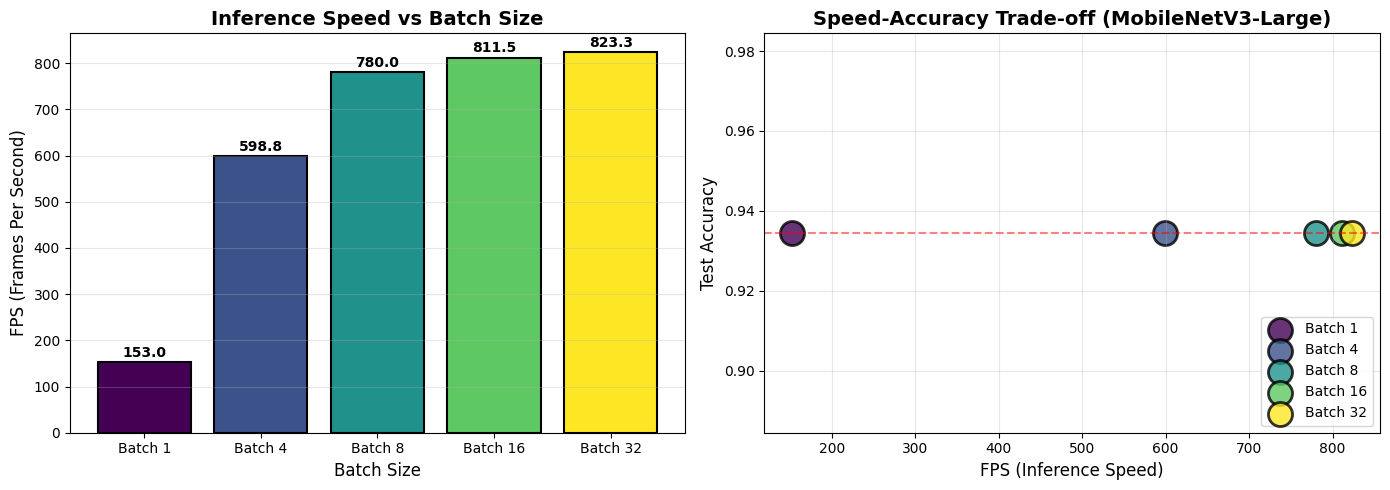


✅ 速度-精度图已保存至: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork\Mobilenetv3-Large\results\speed_accuracy_tradeoff.png

 结果汇总
  模型: MobileNetV3-Large
  测试集精度: 93.44%
  单张推理时间: 6.41ms
  最大FPS (Batch 32): 823.29


In [73]:
# ========== 测量模型推理时间并绘制速度-精度图 ==========

def measure_inference_time(model, device, test_acc, num_iterations=100):
    """
    测量模型推理时间
    
    Args:
        model: 已加载的模型
        device: 设备 (cuda/cpu)
        test_acc: 测试集精度
        num_iterations: 测量迭代次数
    """
    model.eval()
    
    # 生成虚拟输入
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    
    # 预热GPU (重要：确保GPU完全初始化)
    print("🔥 预热GPU...")
    with torch.no_grad():
        for _ in range(20):
            _ = model(dummy_input)
    
    # ========== 单张图片推理时间 ==========
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(dummy_input)
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
    end_time = time.time()
    
    total_time = end_time - start_time
    avg_time_per_image = (total_time / num_iterations) * 1000  # ms
    single_fps = 1 / (total_time / num_iterations)
    
    print(f"\n{'='*60}")
    print(f"📊 推理时间统计 (n={num_iterations} iterations)")
    print(f"{'='*60}")
    print(f"  设备: {device}")
    print(f"  总时间: {total_time:.4f}s")
    print(f"  单张图像推理时间: {avg_time_per_image:.2f}ms")
    print(f"  单张图像FPS: {single_fps:.2f}")
    
    # ========== 不同Batch Size的推理速度 ==========
    batch_sizes = [1, 4, 8, 16, 32]
    fps_list = []
    time_list = []
    
    print(f"\n{'='*60}")
    print(f"📈 不同Batch Size的推理速度")
    print(f"{'='*60}")
    print(f"{'Batch Size':^12} | {'Time/Batch (ms)':^18} | {'FPS':^12}")
    print("-" * 50)
    
    for batch_size in batch_sizes:
        dummy_input = torch.randn(batch_size, 3, 224, 224).to(device)
        
        if device.type == 'cuda':
            torch.cuda.synchronize()
        
        start = time.time()
        with torch.no_grad():
            for _ in range(50):
                _ = model(dummy_input)
        
        if device.type == 'cuda':
            torch.cuda.synchronize()
        elapsed = time.time() - start
        
        fps = (50 * batch_size) / elapsed
        time_per_batch = (elapsed / 50) * 1000  # ms
        
        fps_list.append(fps)
        time_list.append(time_per_batch)
        print(f"{batch_size:^12} | {time_per_batch:^18.2f} | {fps:^12.2f}")
    
    # ========== 绘制速度-精度图 ==========
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 图1: 不同Batch Size的FPS
    ax1 = axes[0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(batch_sizes)))
    bars = ax1.bar(range(len(batch_sizes)), fps_list, color=colors, edgecolor='black', linewidth=1.5)
    ax1.set_xticks(range(len(batch_sizes)))
    ax1.set_xticklabels([f'Batch {bs}' for bs in batch_sizes])
    ax1.set_xlabel('Batch Size', fontsize=12)
    ax1.set_ylabel('FPS (Frames Per Second)', fontsize=12)
    ax1.set_title('Inference Speed vs Batch Size', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 在柱子上显示数值
    for bar, fps in zip(bars, fps_list):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{fps:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 图2: 速度-精度权衡图
    ax2 = axes[1]
    for i, (batch_size, fps) in enumerate(zip(batch_sizes, fps_list)):
        ax2.scatter(fps, test_acc, s=300, alpha=0.8, color=colors[i], 
                   label=f'Batch {batch_size}', edgecolors='black', linewidth=2)
    
    ax2.set_xlabel('FPS (Inference Speed)', fontsize=12)
    ax2.set_ylabel('Test Accuracy', fontsize=12)
    ax2.set_title('Speed-Accuracy Trade-off (MobileNetV3-Large)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10, loc='lower right')
    ax2.grid(True, alpha=0.3)
    
    # 设置Y轴范围
    y_margin = 0.05
    ax2.set_ylim([max(0, test_acc - y_margin), min(1.0, test_acc + y_margin)])
    
    # 添加精度水平线
    ax2.axhline(y=test_acc, color='red', linestyle='--', alpha=0.5, label=f'Acc={test_acc:.4f}')
    
    plt.tight_layout()
    plt.savefig(os.path.join(CFG["result_path"], 'speed_accuracy_tradeoff.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ 速度-精度图已保存至: {os.path.join(CFG['result_path'], 'speed_accuracy_tradeoff.png')}")
    
    # ========== 返回结果汇总 ==========
    results = {
        'single_image_time_ms': avg_time_per_image,
        'single_image_fps': single_fps,
        'batch_fps': dict(zip(batch_sizes, fps_list)),
        'test_accuracy': test_acc
    }
    
    return results

# 加载最优模型
best_model_path = os.path.join(CFG["save_path"], "best_model.pth")
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
print(f"✅ 已加载最优模型: {best_model_path}")

# 测量推理时间（使用之前计算的 test_acc）
inference_results = measure_inference_time(model, device, test_acc, num_iterations=100)

# 打印汇总
print(f"\n{'='*60}")
print(f" 结果汇总")
print(f"{'='*60}")
print(f"  模型: MobileNetV3-Large")
print(f"  测试集精度: {inference_results['test_accuracy']*100:.2f}%")
print(f"  单张推理时间: {inference_results['single_image_time_ms']:.2f}ms")
print(f"  最大FPS (Batch 32): {inference_results['batch_fps'][32]:.2f}")

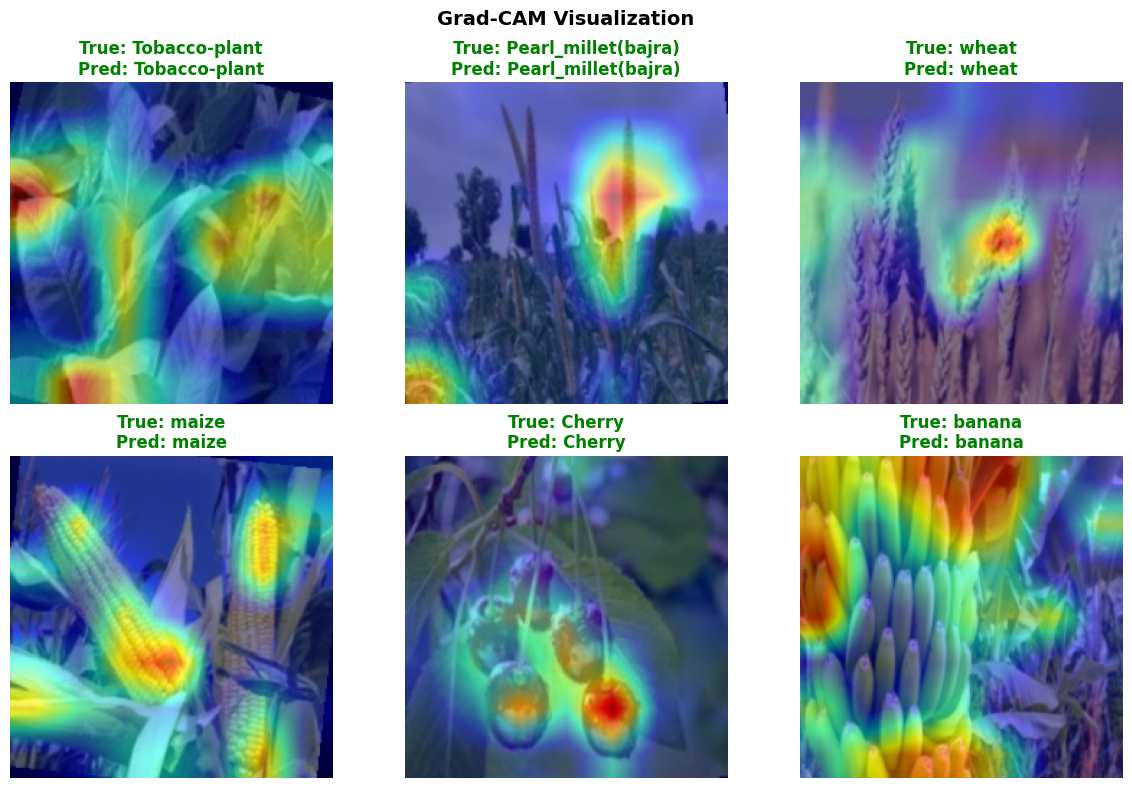

In [74]:
# 可视化Grad-CAM结果
"""
使用Grad-CAM可视化模型关注的区域
"""
# 定义Grad-CAM类
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # 注册钩子
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        
        # 计算权重
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        
        # 归一化
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        
        return cam.squeeze().cpu().numpy(), target_class

# 获取目标层 (MobileNetV3的最后一个卷积层)
target_layer = model.features[-1]
grad_cam = GradCAM(model, target_layer)
num_samples = 6  # 可视化样本数量
result_dir = CFG["result_path"]
import cv2
def visualize_gradcam_predictions(fold_results, class_names, result_dir, num_samples=6):
    """使用Grad-CAM可视化模型关注区域"""    
    # 从测试集采样
    fig, axes = plt.subplots(2, num_samples // 2, figsize=(4 * (num_samples // 2), 8))
    axes = axes.ravel()

    sample_indices = random.sample(range(len(test_dataset)), num_samples)

    for i, idx in enumerate(sample_indices):
        img_tensor, true_label = test_dataset[idx]
        input_tensor = img_tensor.unsqueeze(0).to(device)
        
        # 生成CAM
        cam, pred_class = grad_cam.generate_cam(input_tensor)
        
        # 反标准化图片
        img = img_tensor.cpu()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
            torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()
        
        # 调整CAM大小
        cam_resized = cv2.resize(cam, (224, 224))
        
        # 创建热力图
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
        
        # 叠加
        overlay = 0.5 * img + 0.5 * heatmap
        
        ax = axes[i]
        ax.imshow(overlay)
        
        true_name = class_names[true_label]
        pred_name = class_names[pred_class]
        color = 'green' if true_label == pred_class else 'red'
        ax.set_title(f'True: {true_name}\nPred: {pred_name}', color=color, fontweight='bold')
        ax.axis('off')

    plt.suptitle('Grad-CAM Visualization', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(result_dir, 'gradcam_visualization.png'), dpi=300, bbox_inches='tight')
    plt.show()

# 调用Grad-CAM可视化
visualize_gradcam_predictions(None, class_names, result_dir, num_samples=6)


In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

: 